In [197]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import NMF, PCA
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diegomarquezp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [44]:
text_names=['ID', 'Text']
training_text_df = pd.read_csv('training_text', sep='\\|\\|', engine='python', skiprows=1, names=text_names)
training_variants_df = pd.read_csv('training_variants')
test_text_df = pd.read_csv('test_text', sep='\\|\\|', engine='python', skiprows=1, names=text_names)
test_variants_df = pd.read_csv('test_variants')

In [35]:
training_text_df.head()

ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...

In [12]:
training_variants_df.head()

ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4

In [52]:

training_df = pd.merge(training_variants_df, training_text_df, on='ID', suffixes=('', '_'))
test_df = pd.merge(test_variants_df, test_text_df, on='ID', suffixes=('', '_'))

training_df.head()

ID    Gene             Variation  Class  \
0   0  FAM58A  Truncating Mutations      1   
1   1     CBL                 W802*      2   
2   2     CBL                 Q249E      2   
3   3     CBL                 N454D      3   
4   4     CBL                 L399V      4   

                                                Text  
0  Cyclin-dependent kinases (CDKs) regulate a var...  
1   Abstract Background  Non-small cell lung canc...  
2   Abstract Background  Non-small cell lung canc...  
3  Recent evidence has demonstrated that acquired...  
4  Oncogenic mutations in the monomeric Casitas B...

In [191]:
# Now I'm going to encode the dataframe into a sparse matrix.
# For Gene and Variation, I will use One-Hot encoding (boolean values 0 or 1)
# I will use TF-IDF vectorization for text, where it gives me continous range [0,1] telling the normalized frequency
# That will give me a sparse matrix only with cell values 0 or 1


subset_size = 1000
training_subset = training_df[0:subset_size]
test_subset = test_df[0:subset_size]


lemmatizer = nltk.stem.WordNetLemmatizer()

def tokenizer(text): 
    import re
    pattern = r"(?u)\b\w\w+\b"
    tokens = re.findall(pattern, text)
    result = [lemmatizer.lemmatize(word) for word in tokens]
    return result

# tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, decode_error='ignore', tokenizer=tokenizer, stop_words='english')
# vectorized_training = tfidf.fit_transform(training_subset['Text'].values.astype('U'))
# vectorized_test = tfidf.transform(test_subset['Text'].values.astype('U'))

from gensim.models import Word2Vec
# tokenized_training = training_subset['Text'].apply(lambda text: str(text).lower().split())
# tokenized_test = test_subset['Text'].apply(lambda text: str(text).lower().split())
tokenized_training = training_subset['Text'].apply(tokenizer)
tokenized_test = test_subset['Text'].apply(tokenizer)


print('Tokenization finished')

vector_size = 100
word2vec = Word2Vec(sentences=tokenized_training, vector_size=100, window=5, min_count=1, workers=4)

print('Model training finished')

def get_sentence_vector(word_list, model):
    # Filter out words not in the model's vocabulary
    word_vectors = [model.wv[word] for word in word_list if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size) # Return a zero vector if no words are found

vectorized_training = np.array(tokenized_training.apply(lambda word_list: get_sentence_vector(word_list, word2vec)).to_list())
vectorized_test = np.array(tokenized_test.apply(lambda word_list: get_sentence_vector(word_list, word2vec)).to_list())

print('Vectorization finished')
print(vectorized_training.shape)


Tokenization finished
Model training finished
Vectorization finished
(1000, 100)


In [192]:
onehot = OneHotEncoder()
onehot_training = onehot.fit_transform(training_subset[['Gene', 'Variation']])
onehot_test = onehot.fit_transform(test_subset[['Gene', 'Variation']])


In [193]:
training_matrix = sp.hstack((onehot_training, vectorized_training))
test_matrix = sp.hstack((onehot_test, vectorized_test))

In [196]:
# we can't use nmf over word2vec because vectors have negative values
# nmf = NMF(n_components=3, init='nndsvda')
# training_3d_nmf = nmf.fit_transform(training_matrix)

In [198]:
pca = PCA(n_components=10)
training_pca = pca.fit_transform(training_matrix)

In [144]:
def draw_3d_graph(X_3d, y_classes, N=100):
    # Create a figure and a set of subplots
    fig = plt.figure(figsize=(10, 8))
    
    # Add a 3D subplot (projection='3d' is key)
    ax = fig.add_subplot(111, projection='3d')
    
    # Separate the 3 components into X, Y, and Z arrays
    x_coords = X_3d[:, 0]
    y_coords = X_3d[:, 1]
    z_coords = X_3d[:, 2]
    
    # Generate the scatter plot
    # c=y_classes: uses the class numbers for coloring
    # cmap='Spectral': specifies the colormap to use (Matplotlib will map 1-9 to colors)
    scatter = ax.scatter(
        x_coords, 
        y_coords, 
        z_coords, 
        c=y_classes, 
        cmap='Spectral', 
        marker='o', 
        s=20 # size of the points
    )
    
    # --- 3. Labeling and Aesthetics ---
    
    ax.set_xlabel('Topic 1')
    ax.set_ylabel('Topic 2')
    ax.set_zlabel('Topic 3')
    
    # Add a color bar to show the mapping from class number to color
    legend = fig.colorbar(scatter, ax=ax, pad=0.1)
    legend.set_label('Genetic Mutation Class')
    # Set the title
    ax.set_title('3D Visualization of Mutation Embeddings')
    
    # Show the plot
    plt.show()

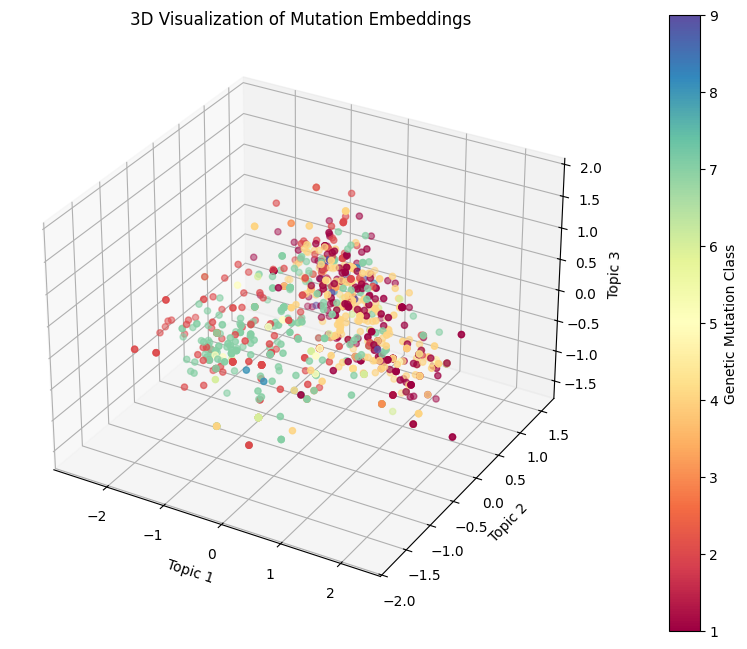

In [199]:
draw_3d_graph(training_pca, training_subset['Class'])

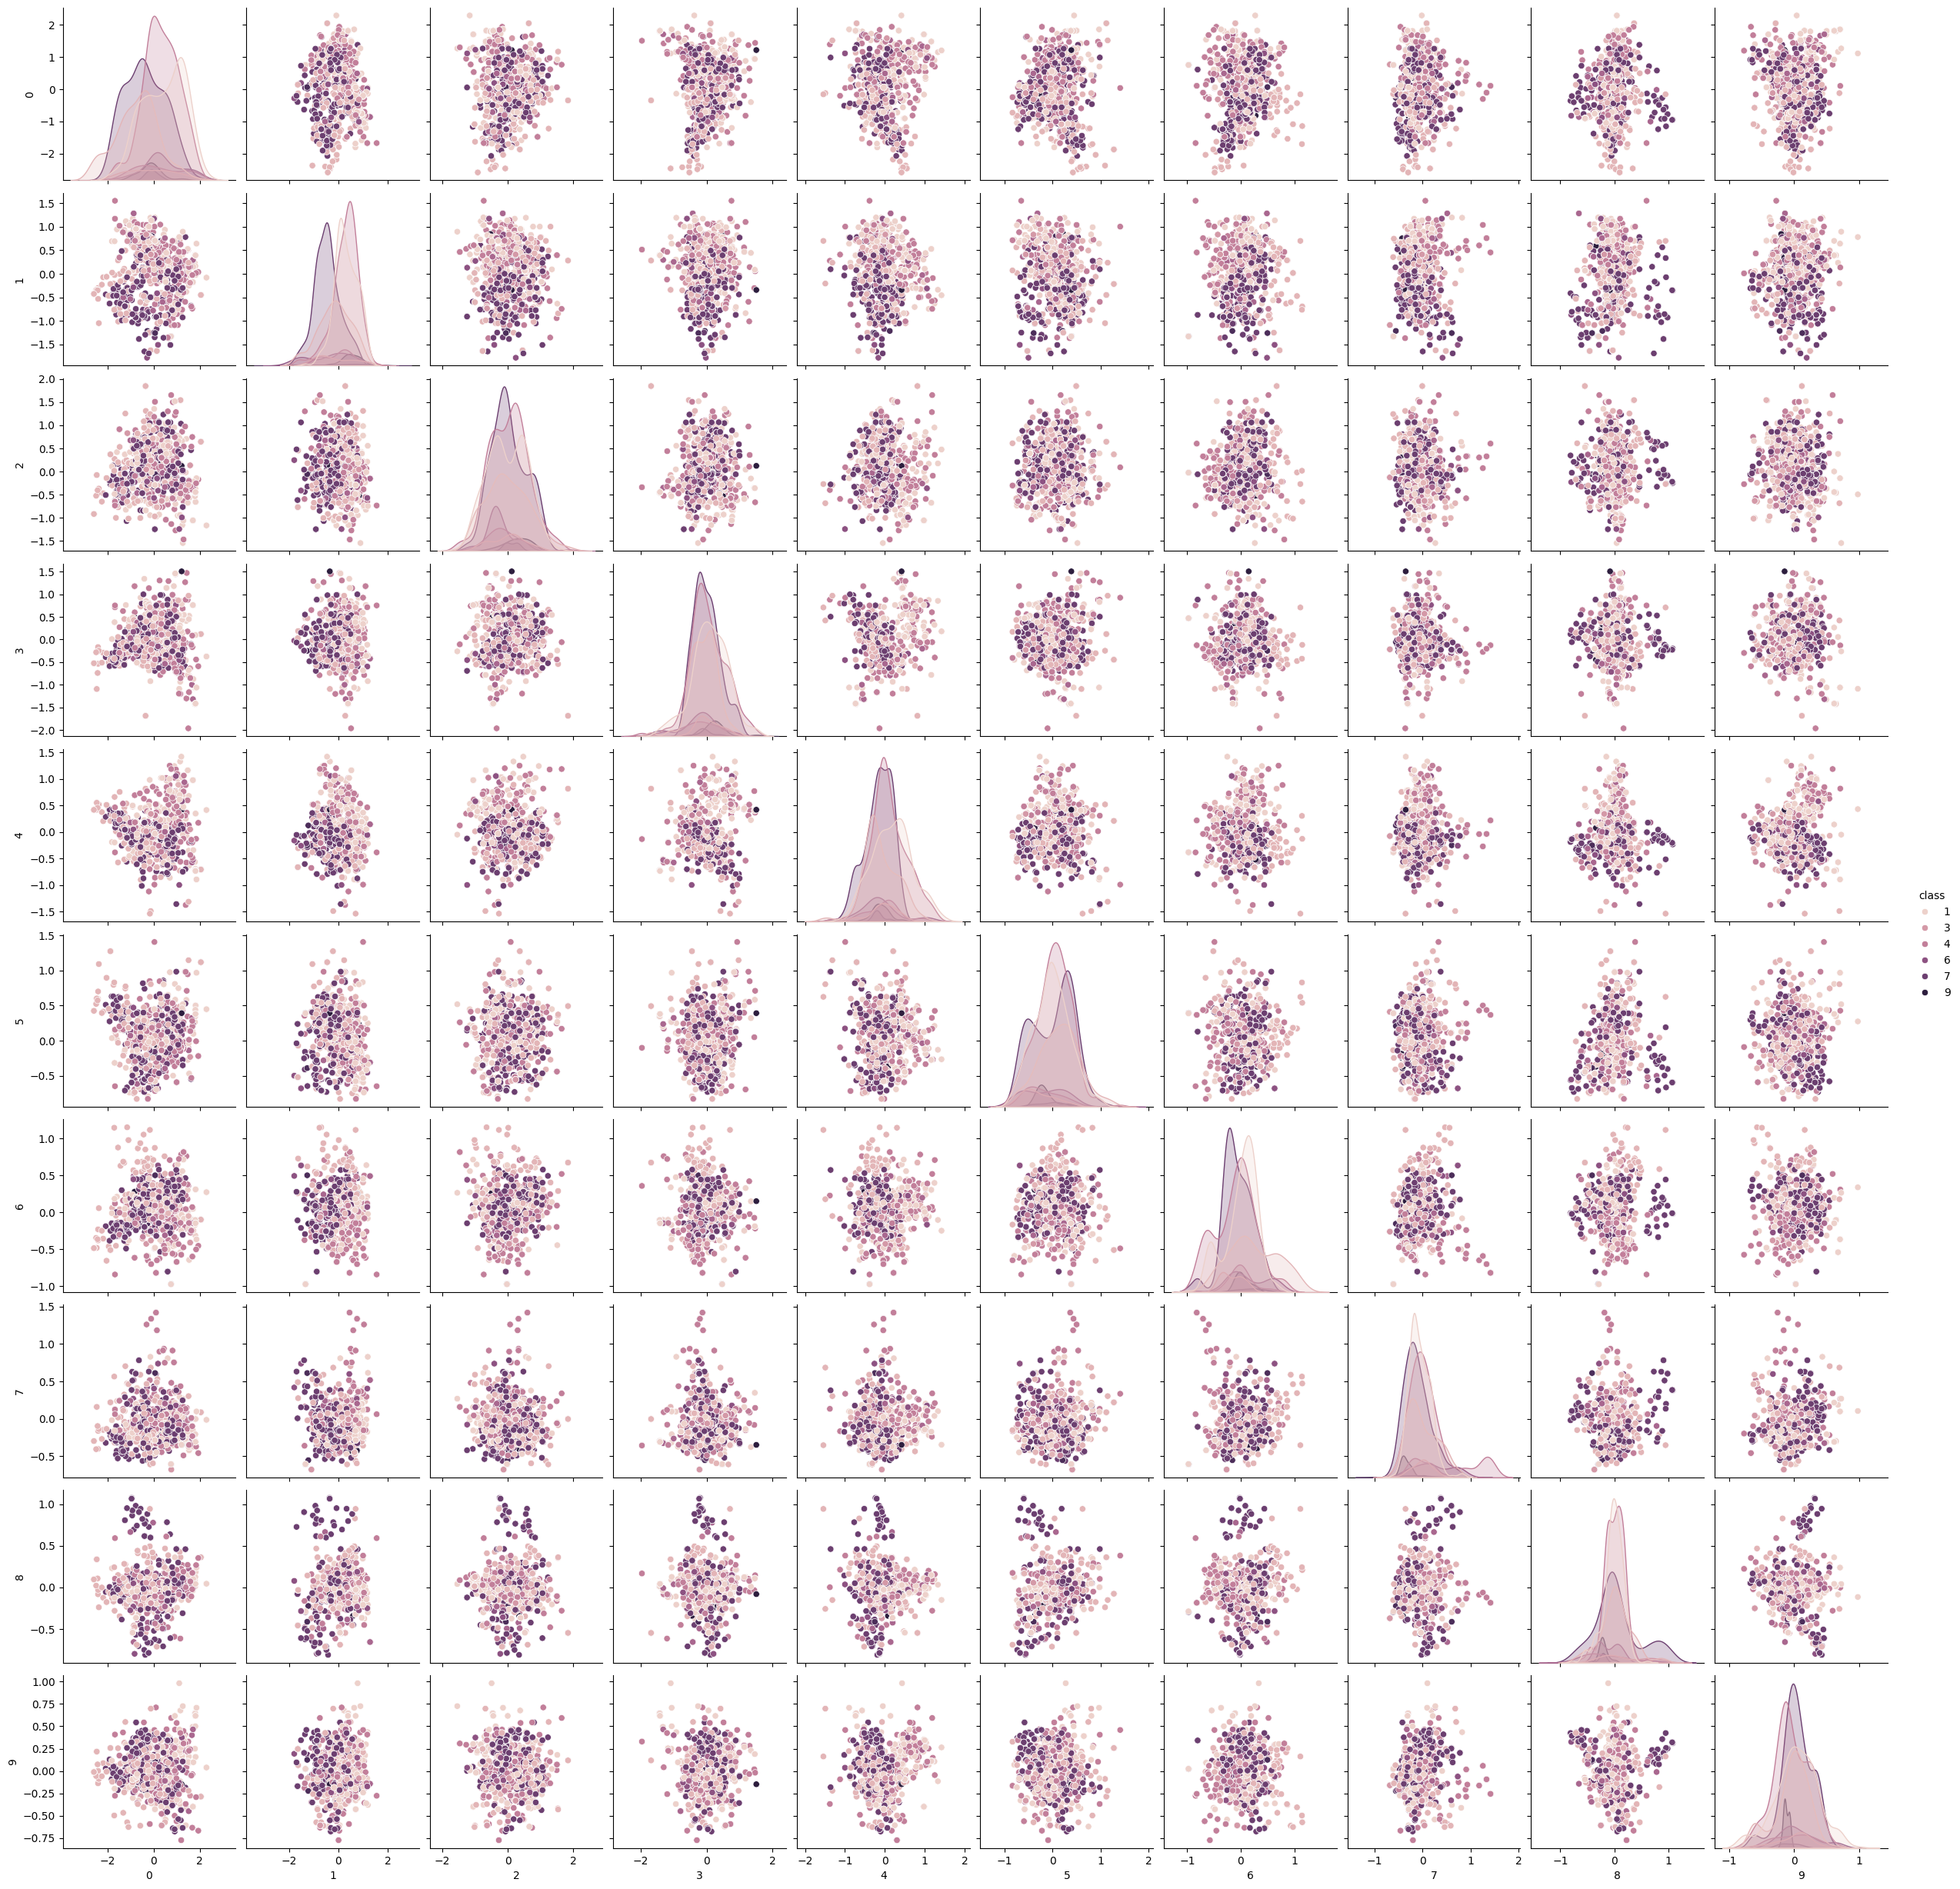

In [207]:
training_pca_df = pd.DataFrame(training_pca)
training_pca_df['class'] = training_subset['Class']
sns.pairplot(pd.DataFrame(training_pca_df), hue='class');

In [208]:
# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
import umap
umap_pca = umap.UMAP(n_components=10)
training_umap = umap_pca.fit_transform(training_matrix)

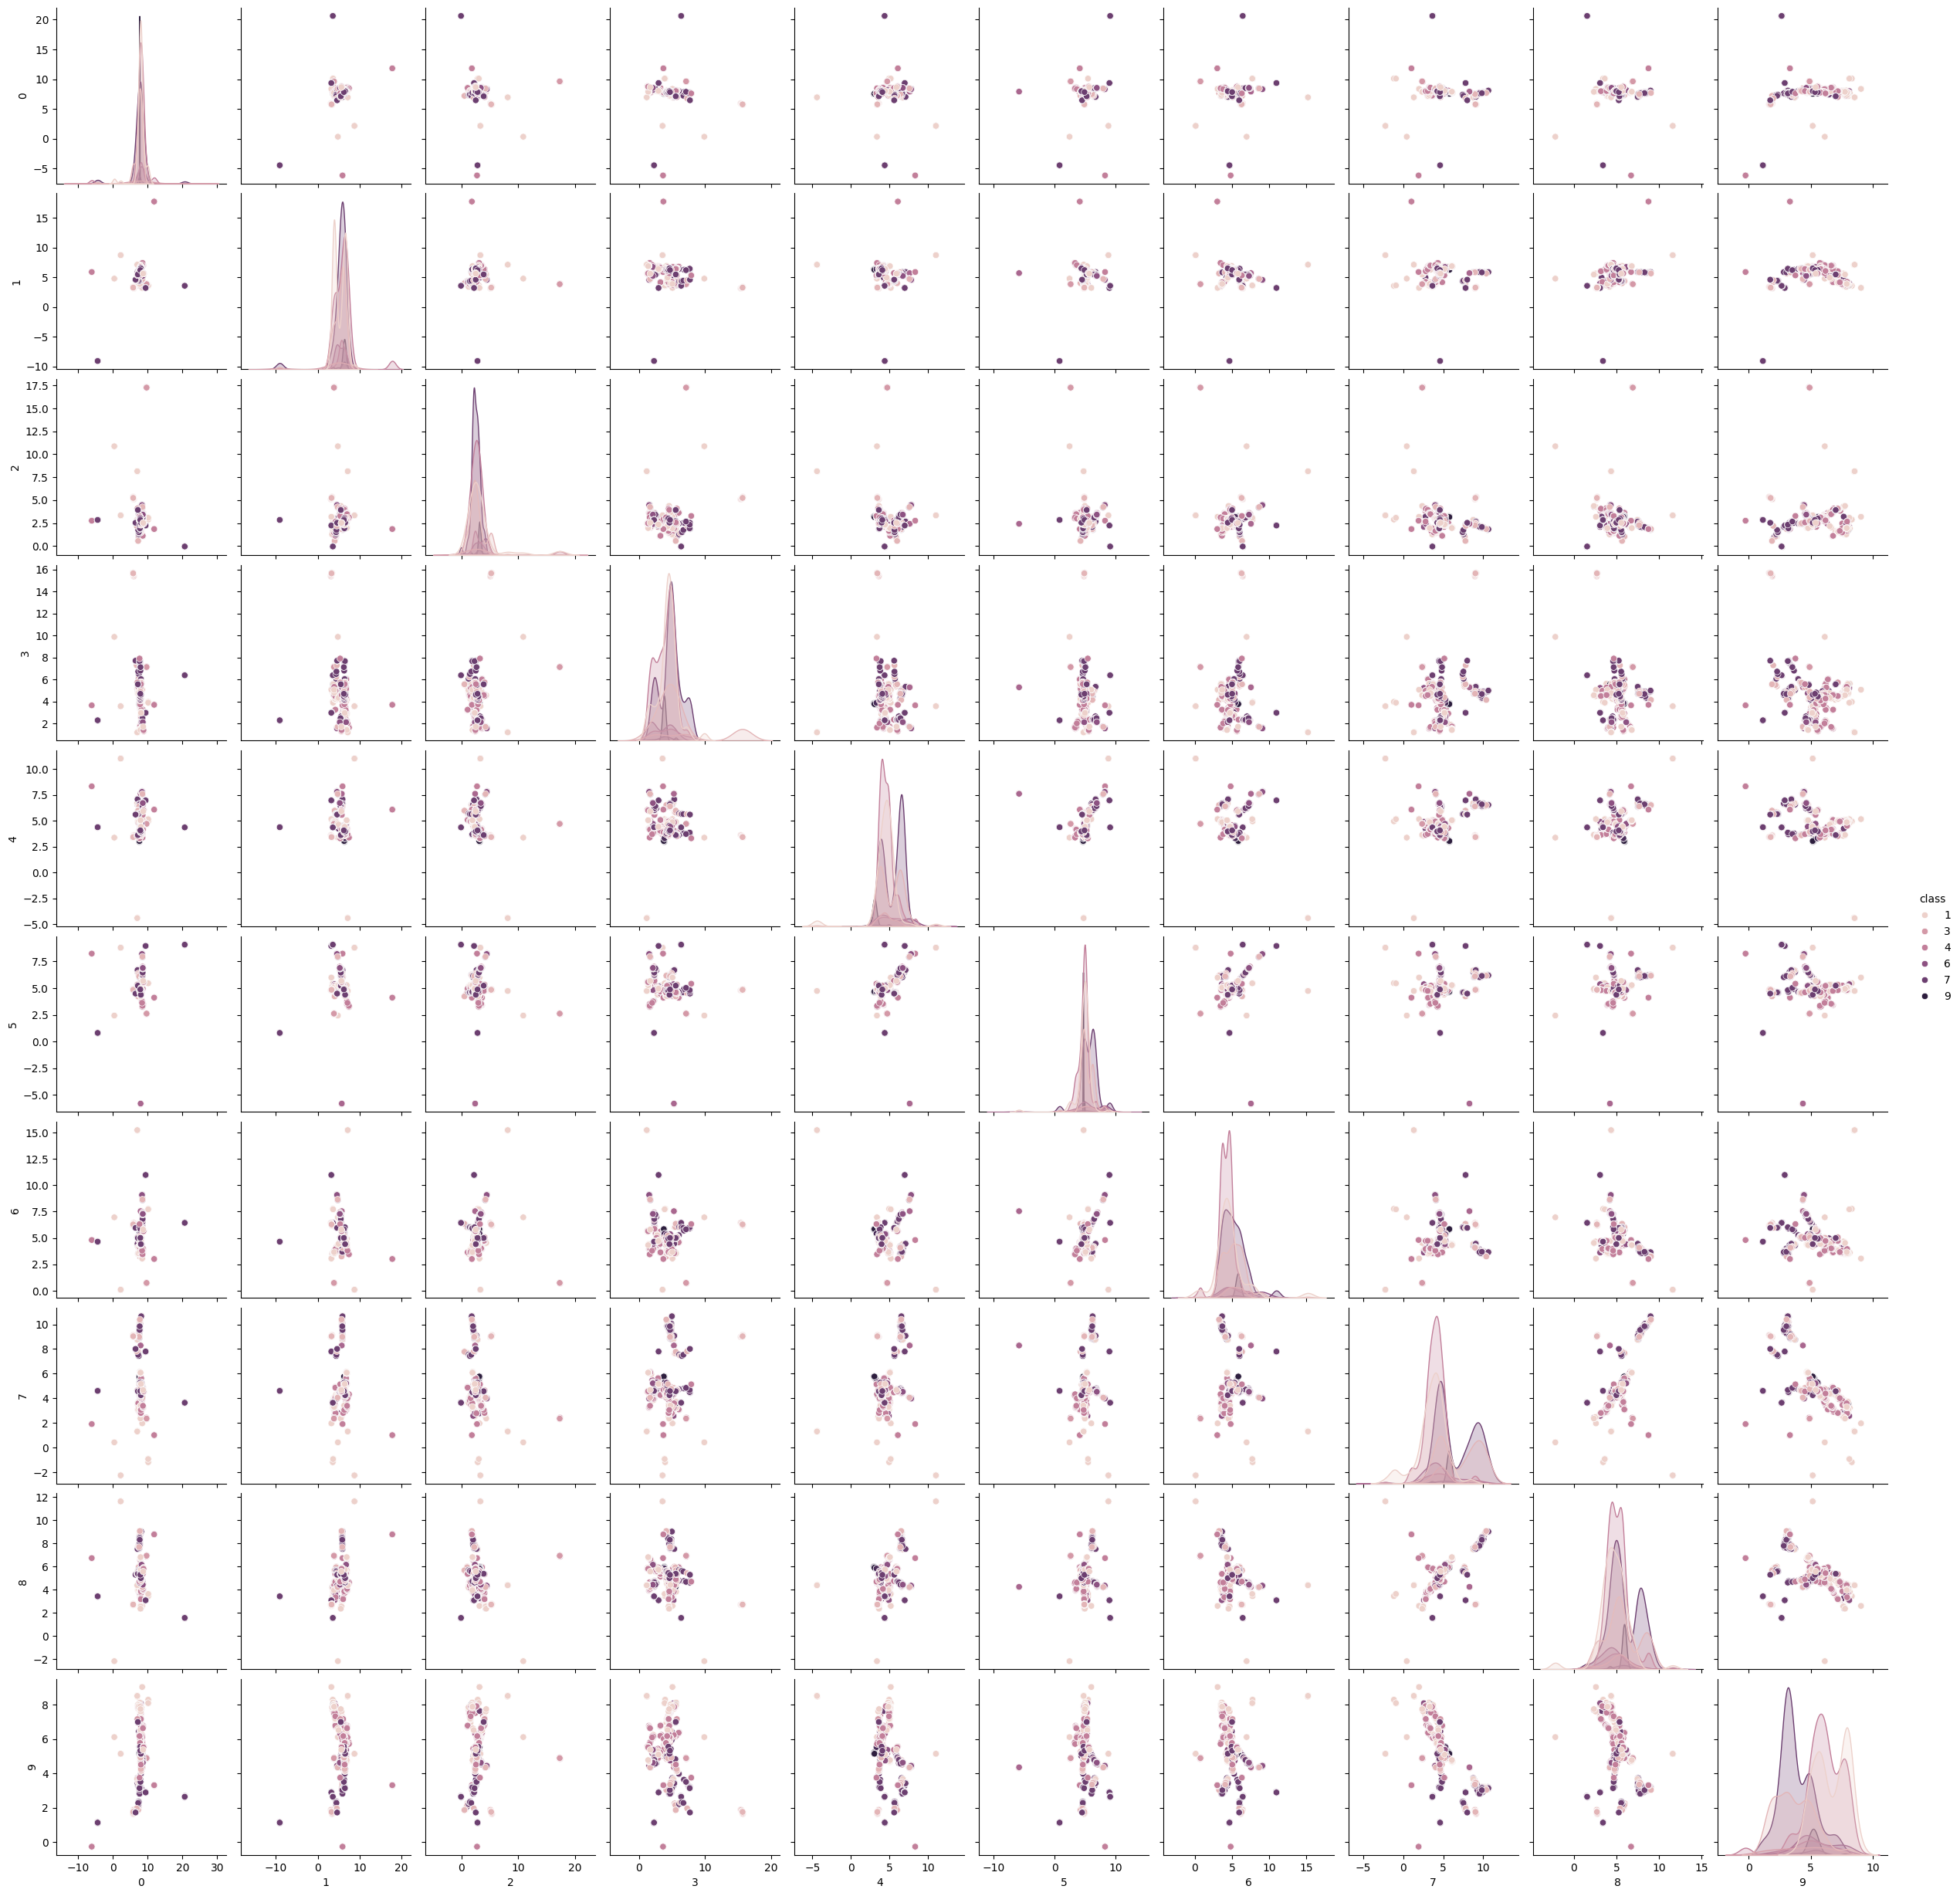

In [209]:
training_umap_df = pd.DataFrame(training_umap)
training_umap_df['class'] = training_subset['Class']
sns.pairplot(pd.DataFrame(training_umap_df), hue='class');

In [220]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from itertools import permutations
from sklearn.metrics import adjusted_rand_score
# kmeans = KMeans(n_clusters=9)
# y_pred = kmeans.fit_predict(training_matrix)

# max_accuracy = 0
y_true = training_subset['Class'].to_list()
# for permutation in permutations(list(range(9))):
#     y_pred_perm = [permutation[y - 1] for y in y_pred]
#     max_accuracy = max(accuracy_score(y_true, y_pred_perm), max_accuracy)

# print(max_accuracy)
adjusted_rand_score(y_true, y_pred)

0.0904694541760495